**Software Evolution** is the process of developing software and maintaining it over time. It involves the continuous improvement and adaptation of software systems to meet changing requirements, fix bugs, and enhance performance. Software evolution is a critical aspect of software engineering, as it ensures that software remains relevant and effective in a dynamic environment. With the rapid pace of technological advancements and changing user needs, the configuration space continuesly increases in terms of technologies and their configuration options.

In [3]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import glob
from typing import Dict, List
from collections import defaultdict



data_file = "../data/test_projects/piggymetrics.json"

with open(data_file, "r", encoding="utf-8") as src:
    data = json.load(src)

*How does the configuration space of open-source software projects evolve?*

/var/folders/sv/pdgl__6900j8c78ybv1j2hjw0000gp/T/ipykernel_22141/4209324245.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


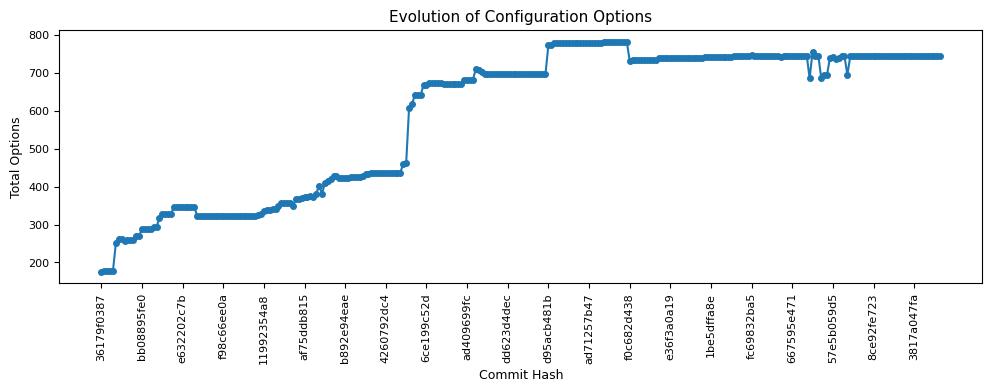

In [4]:
def plot_option_evolution(data: Dict):
    project_name = data["project_name"]
    last_count = 0
    commit_hashes = []
    option_counts = []

    for commit in data["commit_data"]:
        commit_hash = commit["commit_hash"]
        if commit["is_config_related"]:
            last_count = commit["network_data"]["total_options"]
        commit_hashes.append(commit_hash)
        option_counts.append(last_count)

    step = max(1, len(commit_hashes) // 20)
    shortened_x = [commit_hashes[i][:10] for i in range(0, len(commit_hashes), step)]

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(range(len(option_counts)), option_counts, marker='o', markersize=4, linestyle='-')

    ax.set_xticks(range(0, len(option_counts), step))
    ax.set_xticklabels(shortened_x, rotation=90, fontsize=8)

    ax.set_xlabel('Commit Hash', fontsize=9)
    ax.set_ylabel('Total Options', fontsize=9)
    ax.set_title('Evolution of Configuration Options', fontsize=11)
    ax.tick_params(axis='y', labelsize=8)

    fig.tight_layout(pad=1.0)
    fig.savefig(f"../data/figures/option_evolution_{project_name}.png")
    fig.show()

plot_option_evolution(data)

In [18]:
# Extract commit data
commits = data['commit_data']

# Gather relevant info for each commit
rows = []
file_history = []  # To track config files per commit

for c in commits:
    if not c['is_config_related']:
        file_history.append(set())  # Maintain alignment
        continue
    total_options = sum(f['options'] for f in c['network_data']['config_file_data'])
    commit_hash = c['commit_hash']
    commit_msg = c.get('commit_mgs', '')
    changed_files = sum(1 for f in c['network_data']['config_file_data'] if f.get('is_modified', False))
    current_files = set(f['file_path'] for f in c['network_data']['config_file_data'])
    file_history.append(current_files)
    rows.append({
        'commit_hash': commit_hash,
        'total_options': total_options,
        'commit_msg': commit_msg,
        'num_changed_files': changed_files,
        'current_files': current_files,
        'modified_files': [f['file_path'] for f in c['network_data']['config_file_data'] if f.get('is_modified', False)]
    })

df = pd.DataFrame(rows)

# Calculate option changes
df['option_change'] = df['total_options'].diff()
df['abs_change'] = df['option_change'].abs()
df['pct_change'] = df['option_change'] / df['total_options'].shift(1)

# Thresholds for significant change
PCT_THRESHOLD = 0.30  # 10%
ABS_THRESHOLD = 30    # Adjust as needed

# Detect significant events
events = df[
    (df['abs_change'] > ABS_THRESHOLD) |
    (df['pct_change'].abs() > PCT_THRESHOLD)
].copy()

# Classify direction
events['direction'] = events['option_change'].apply(lambda x: 'increase' if x > 0 else 'decrease')

# Select relevant columns for output, including percentage change and file changes
output_cols = [
    'commit_hash', 'option_change', 'direction', 'pct_change',
    'commit_msg', 'num_changed_files',
]
event_summary = events[output_cols]

# Convert percentage change to percent and round for readability
event_summary['pct_change'] = (event_summary['pct_change'] * 100).round(2)

# Sort by absolute percentage change, descending
event_summary = event_summary.reindex(event_summary['pct_change'].abs().sort_values(ascending=False).index)

# Print the summary
if event_summary.empty:
    print("No significant events detected.")
else:
    print(event_summary.to_string(index=False))

                             commit_hash  option_change direction  pct_change                                                                                                                                                                                                                                                                                                 commit_msg  num_changed_files
27474a9d463490380fb4da564c3de92ed6d518d2           73.0  increase       41.01                                                                                                                                                                                                                                                                                          spring profiles\n                  1
fb64a0e54b94f3713824a3bdc8369ff5166875bd          145.0  increase       31.45                                                                                                                                   

/var/folders/sv/pdgl__6900j8c78ybv1j2hjw0000gp/T/ipykernel_22141/451203087.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_summary['pct_change'] = (event_summary['pct_change'] * 100).round(2)


*How does the configuration space of technologies used to build software evolve?*

/var/folders/sv/pdgl__6900j8c78ybv1j2hjw0000gp/T/ipykernel_11112/4092391063.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


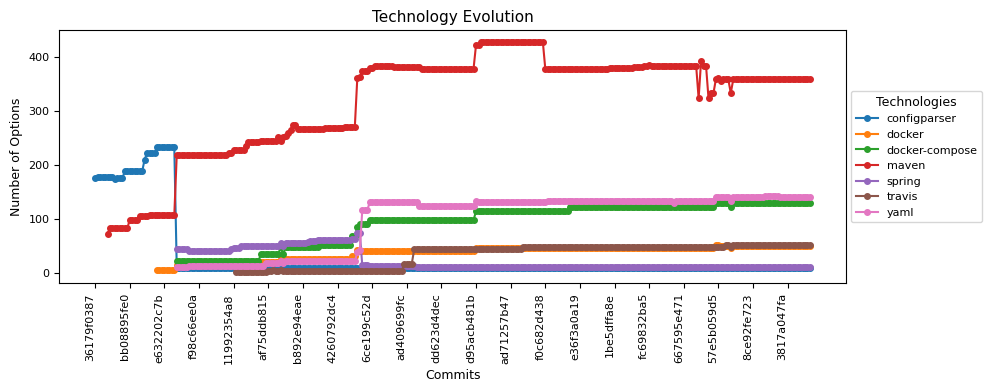

In [3]:
def plot_technology_evolution(data: Dict):
    project_name = data["project_name"]
    concepts = set()
    all_commits = data["commit_data"]
    x_ticks = [commit["commit_hash"] for commit in all_commits]

    concept_lines = defaultdict(lambda: [None] * len(x_ticks))

    for i, commit in enumerate(all_commits):
        if commit.get("is_config_related") and "network_data" in commit and "config_file_data" in commit["network_data"]:
            concept_counts = defaultdict(int)
            for config_file in commit["network_data"]["config_file_data"]:
                concept = config_file.get("concept")
                options = config_file.get("options", 0)
                if concept:
                    concepts.add(concept)
                    concept_counts[concept] += options
            for concept, count in concept_counts.items():
                concept_lines[concept][i] = count

    # Forward fill
    for concept in concepts:
        last_value = None
        for i in range(len(x_ticks)):
            if concept_lines[concept][i] is None:
                concept_lines[concept][i] = last_value
            else:
                last_value = concept_lines[concept][i]

    shortened_x_ticks = [commit[:10] for commit in x_ticks]
    step = max(1, len(shortened_x_ticks) // 20)

    fig, ax = plt.subplots(figsize=(10, 4))
    for concept in sorted(concepts):
        ax.plot(shortened_x_ticks, concept_lines[concept], marker='o', markersize=4, label=concept)

    ax.set_xlabel("Commits", fontsize=9)
    ax.set_ylabel("Number of Options", fontsize=9)
    ax.set_title("Technology Evolution", fontsize=11)
    ax.set_xticks(range(0, len(shortened_x_ticks), step))
    ax.set_xticklabels(shortened_x_ticks[::step], rotation=90, ha="right", fontsize=8)
    ax.tick_params(axis='y', labelsize=8)

    ax.legend(title="Technologies", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=8, title_fontsize=9)
    fig.tight_layout(pad=1.0)
    fig.savefig(f"../data/figures/technology_evolution_{project_name}.png")
    fig.show()

plot_technology_evolution(data)

*How does the configuration space of configuration files evolve?*

/var/folders/sv/pdgl__6900j8c78ybv1j2hjw0000gp/T/ipykernel_11112/3718476910.py:43: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(pad=1.0)
/var/folders/sv/pdgl__6900j8c78ybv1j2hjw0000gp/T/ipykernel_11112/3718476910.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


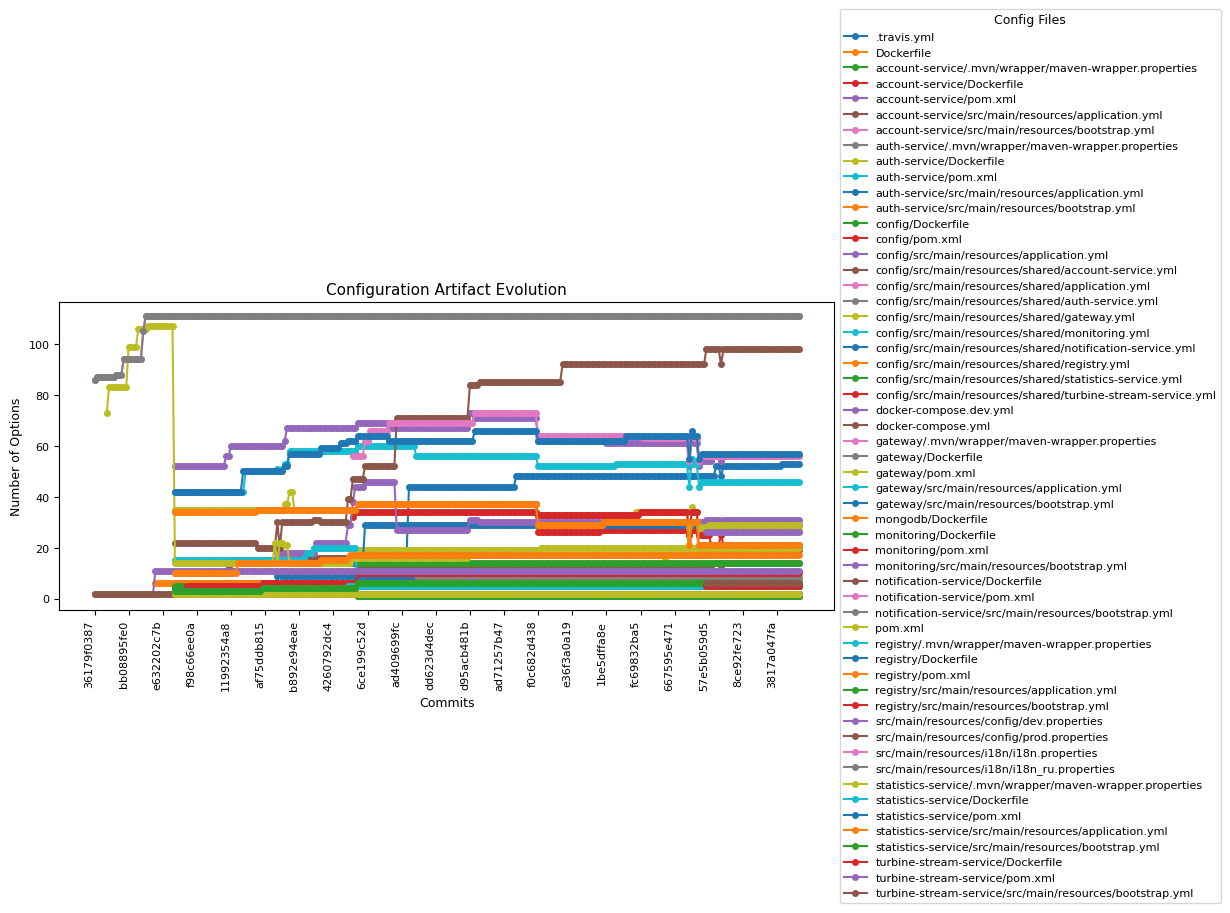

In [4]:
def plot_artifact_evolution(data: Dict):
    project_name = data["project_name"]
    file_paths = set()
    file_lines = defaultdict(lambda: [None] * len(data["commit_data"]))
    x_ticks = [commit["commit_hash"] for commit in data["commit_data"]]

    # Fill values for config-related commits
    for i, commit in enumerate(data["commit_data"]):
        if commit.get("is_config_related") and "network_data" in commit and "config_file_data" in commit["network_data"]:
            for config_file in commit["network_data"]["config_file_data"]:
                file_path = config_file.get("file_path")
                options = config_file.get("options", 0)
                if file_path:
                    file_paths.add(file_path)
                    file_lines[file_path][i] = options

    # Forward-fill missing values
    for file_path in file_paths:
        last_value = None
        for i in range(len(x_ticks)):
            if file_lines[file_path][i] is None:
                file_lines[file_path][i] = last_value
            else:
                last_value = file_lines[file_path][i]

    shortened_x_ticks = [commit[:10] for commit in x_ticks]
    step = max(1, len(shortened_x_ticks) // 20)

    # Create compact figure
    fig, ax = plt.subplots(figsize=(10, 4))
    for file_path in sorted(file_paths):
        ax.plot(shortened_x_ticks, file_lines[file_path], marker="o", markersize=4, label=file_path)

    ax.set_xlabel("Commits", fontsize=9)
    ax.set_ylabel("Number of Options", fontsize=9)
    ax.set_title("Configuration Artifact Evolution", fontsize=11)

    ax.set_xticks(range(0, len(shortened_x_ticks), step))
    ax.set_xticklabels(shortened_x_ticks[::step], rotation=90, ha="right", fontsize=8)
    ax.tick_params(axis='y', labelsize=8)

    ax.legend(title="Config Files", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=8, title_fontsize=9)
    fig.tight_layout(pad=1.0)
    fig.savefig(f"../data/figures/artifact_evolution_{project_name}")
    fig.show()

plot_artifact_evolution(data)

**Summarization of Statistics about the configuration space**

Columns:
- Project Name
- \# Total Commits
- \# Config-related Commits
- \# Technologies in first config-related commit
- \# Configuration files in first config-related commit
- \# Options in first config-related commit
- \# Technologies in latest commit
- \# Configuration files in lated commit
- \# Options in latest commit
- Growth of technologies in percent
- Growth of configuration files in percent
- Growth of options in percent
- Avg. # Options added per config-related commit
- Avg. # Options removed per config-related commit 
- Avg. # Options modified per config-related commit

In [8]:
import csv
from typing import Dict

def extract_configuration_stats(data: Dict):
    project_name = data["project_name"]
    commits = data["commit_data"]
    total_commits = len(commits)
    config_related_commits = [commit for commit in commits if commit["is_config_related"]]

    # First and latest config-related commits
    first_commit = config_related_commits[0]
    latest_commit = next(filter(lambda commit: commit["is_latest_commit"] == True, commits))

    # Extract stats for first and latest config-related commits
    first_technologies = len(first_commit["network_data"]["concepts"])
    first_config_files = len(first_commit["network_data"]["config_file_data"])
    first_options = first_commit["network_data"]["total_options"]

    latest_technologies = len(latest_commit["network_data"]["concepts"])
    latest_config_files = len(latest_commit["network_data"]["config_file_data"])
    latest_options = latest_commit["network_data"]["total_options"]

    # Calculate growth percentages
    tech_growth = ((latest_technologies - first_technologies) / first_technologies) * 100 if first_technologies > 0 else 0
    config_files_growth = ((latest_config_files - first_config_files) / first_config_files) * 100 if first_config_files > 0 else 0
    options_growth = ((latest_options - first_options) / first_options) * 100 if first_options > 0 else 0

    # Calculate average options added, removed, and modified per config-related commit
    options_added = []
    options_removed = []
    options_modified = []

    for commit in config_related_commits:
        removed_options = 0
        added_options = 0
        modified_options = 0

        for modified_file in commit["network_data"]["config_file_data"]:
            modified_options += len(modified_file["modified_pairs"])
            removed_options += len(modified_file["removed_pairs"])
            added_options += len(modified_file["added_pairs"])

        options_modified.append(modified_options)
        options_added.append(added_options)
        options_removed.append(removed_options)

    avg_options_added = sum(options_added) / len(config_related_commits) if options_added else 0
    avg_options_removed = sum(options_removed) / len(config_related_commits) if options_removed else 0
    avg_options_modified = sum(options_modified) / len(config_related_commits) if options_modified else 0

    ## Prepare the data for the DataFrame
    stats = {
        "Project Name": [project_name],
        "# Total Commits": [total_commits],
        "# Config-related Commits": [len(config_related_commits)],
        "# Technologies in first config-related commit": [first_technologies],
        "# Configuration files in first config-related commit": [first_config_files],
        "# Options in first config-related commit": [first_options],
        "# Technologies in latest commit": [latest_technologies],
        "# Configuration files in latest commit": [latest_config_files],
        "# Options in latest commit": [latest_options],
        "Growth of technologies in percent": [round(tech_growth, 2)],
        "Growth of configuration files in percent": [round(config_files_growth, 2)],
        "Growth of options in percent": [round(options_growth, 2)],
        "Avg. # Options added per config-related commit": [round(avg_options_added, 1)],
        "Avg. # Options removed per config-related commit": [round(avg_options_removed, 1)],
        "Avg. # Options modified per config-related commit": [round(avg_options_modified, 1)],
    }

    # Create a DataFrame and save it to a CSV file
    df = pd.DataFrame(stats)

    return df


project_files = glob.glob("../data/test_projects/*.json")

df_list = []

for project_file in project_files:
    with open(project_file, "r", encoding="utf-8") as src:
        data = json.load(src)
        project_df = extract_configuration_stats(data)
        df_list.append(project_df)
    

df_all = pd.concat(df_list)
df_all

,Project Name,# Total Commits,# Config-related Commits,# Technologies in first config-related commit,# Configuration files in first config-related commit,# Options in first config-related commit,# Technologies in latest commit,# Configuration files in latest commit,# Options in latest commit,Growth of technologies in percent,Growth of configuration files in percent,Growth of options in percent,Avg. # Options added per config-related commit,Avg. # Options removed per config-related commit,Avg. # Options modified per config-related commit
0,piggymetrics,290,135,1,4,176,6,41,744,500.0,925.0,322.73,13.3,6.0,1.6
0,test-config-repo,7,7,2,2,39,5,5,79,150.0,150.0,102.56,11.7,1.1,0.4
